# Supp Figure 1-Z

In [1]:
from libraries import *
from parameters import *


In [2]:
os.getcwd()
os.chdir(projectDir)

In [3]:
%load_ext rpy2.ipython

In [4]:
adata1 = sc.read('outputs/anndata/adata-hash-features_singlets_MultipleKO_06292020_PerGENE.h5ad')
adata2 = sc.read('outputs/anndata/adata-hash-features_singlets_SingleKO_06292020_PerGENE.h5ad')



In [5]:
adata = sc.concat([adata1, adata2], )

In [6]:
covariates = adata1.uns['feature_barcode_names_filtered_GENES']
covariates = covariates[covariates != "GENE_CONTROL_"]
covariates = covariates[covariates != "GENE_INEFFECT_"]

In [7]:
fBarMat = adata.obs[covariates]
fBarMat[fBarMat>0] = 1
fBarMat["leiden"] = adata.obs['leiden']
fBarMat.shape

/tmp/ipykernel_96005/402531527.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fBarMat[fBarMat>0] = 1
/tmp/ipykernel_96005/402531527.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fBarMat[fBarMat>0] = 1
/tmp/ipykernel_96005/402531527.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fBarMat["leiden"] = adata.obs[

(323923, 1032)

In [8]:
allGuidesPerSCT = pd.DataFrame()

for elem in covariates:
    k = pd.DataFrame(pd.crosstab(fBarMat[elem], fBarMat.leiden))
    k = k.loc[k.index == 1,]
    k["KOGuide"] = elem
    allGuidesPerSCT = allGuidesPerSCT.append(k)

allGuidesPerSCT['noOfGuideCells'] = allGuidesPerSCT.loc[:,["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]].sum(axis=1)

/tmp/ipykernel_96005/2439476341.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allGuidesPerSCT = allGuidesPerSCT.append(k)
/tmp/ipykernel_96005/2439476341.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allGuidesPerSCT = allGuidesPerSCT.append(k)
/tmp/ipykernel_96005/2439476341.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allGuidesPerSCT = allGuidesPerSCT.append(k)
/tmp/ipykernel_96005/2439476341.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allGuidesPerSCT = allGuidesPerSCT.append(k)
/tmp/ipykernel_96005/2439476341.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

In [14]:
%%R  -i allGuidesPerSCT

lappend <- function(lst, obj) {
  lst[[length(lst)+1]] <- obj
  return(lst)
}


#allGuidesPerSCT <- readRDS("/home/beraslan/jovian-work/analysisSingle/outputs/RDSFiles/allGuidesPerLeiden_PERGENE.rds")


allGuidesPerSCT$KOGuide <- as.character(allGuidesPerSCT$KOGuide)
rownames(allGuidesPerSCT) <- allGuidesPerSCT$KOGuide

for(i in 0:9){
    allGuidesPerSCT[paste0("Leiden",i,"_pval_greater")] = -1
    allGuidesPerSCT[paste0("Leiden",i,"_estimate_greater")] = -1
    allGuidesPerSCT[paste0("Leiden",i,"_pval_less")] = -1
    allGuidesPerSCT[paste0("Leiden",i,"_estimate_less")] = -1
    
}

totalCountsPerSCT <- data.frame(leiden = c("0", "1", "2", "3", "4", "5", "6", "7", "8", "9"),
                                cellCounts = colSums(allGuidesPerSCT[,c("0", "1", "2", "3", "4", "5", "6", "7", "8", "9")]))
rownames(totalCountsPerSCT) = totalCountsPerSCT$leiden
totalNoOfCells = sum(totalCountsPerSCT$cellCounts)


depletedGuides <- list()

for (elem in as.character(unique(allGuidesPerSCT$KOGuide))){
    
    
    if(allGuidesPerSCT[elem, "noOfGuideCells"] == 0){
        depletedGuides <- lappend(depletedGuides, elem)
    }else{
        
        for(leiden in c("0", "1", "2", "3", "4", "5", "6", "7", "8", "9")){
           myDF = data.frame(clusterNo = c(allGuidesPerSCT[elem, leiden], allGuidesPerSCT[elem, "noOfGuideCells"] - allGuidesPerSCT[elem, leiden]),
                  restNo = c(totalCountsPerSCT[leiden,"cellCounts"], totalNoOfCells - totalCountsPerSCT[leiden,"cellCounts"]))
        
           
           testRes_g <- fisher.test(x= myDF, alternative = "greater")
           allGuidesPerSCT[elem, paste0("Leiden",leiden,"_pval_greater")] = testRes_g$p.value
           allGuidesPerSCT[elem, paste0("Leiden",leiden,"_estimate_greater")] = testRes_g$estimate
                        
           testRes_l <- fisher.test(x= myDF, alternative = "less")
           allGuidesPerSCT[elem, paste0("Leiden",leiden,"_pval_less")] = testRes_l$p.value
           allGuidesPerSCT[elem, paste0("Leiden",leiden,"_estimate_less")] = testRes_l$estimate
                        
        }
        
    }  
}


for(i in 0:9){
    allGuidesPerSCT[paste0("Leiden",i,"_FDR_greater")] <- p.adjust(allGuidesPerSCT[,paste0("Leiden",i,"_pval_greater")])
    allGuidesPerSCT[paste0("Leiden",i,"_FDR_less")] <- p.adjust(allGuidesPerSCT[,paste0("Leiden",i,"_pval_less")])  
}


#saveRDS(allGuidesPerSCT, "/home/beraslan/jovian-work/analysisSingle/outputs/RDSFiles/allGuidesPerLeiden_withTests_PERGENE.rds")


In [9]:
%%R -w 6 -h 25 -u in
"%ni%" = Negate( "%in%" )

library("reshape2")

allGuidesPerSCT <- readRDS("./outputs/RDSFiles/allGuidesPerLeiden_withTests_PERGENE.rds")

allGuidesPerSCT_FDRs <- allGuidesPerSCT[,c(paste0("Leiden",0:9,"_FDR_greater"), paste0("Leiden",0:9,"_FDR_less"), "KOGuide")]


allGuidesPerSCT_FDRs_melted <- melt(allGuidesPerSCT_FDRs, id.vars="KOGuide")
allGuidesPerSCT_FDRs_melted <- allGuidesPerSCT_FDRs_melted[allGuidesPerSCT_FDRs_melted$value < 0.15,]


allGuidesPerSCT_FDRs_melted$celltype <- sapply(allGuidesPerSCT_FDRs_melted$variable,
                                               function(x){strsplit(as.character(x),"_")[[1]][1]})
allGuidesPerSCT_FDRs_melted$testType <- sapply(allGuidesPerSCT_FDRs_melted$variable,
                                               function(x){strsplit(as.character(x),"_")[[1]][3]})

allGuidesPerSCT_FDRs_melted$oddRatio = 1


#head(allGuidesPerSCT[c("GENE_Cacybp_", "GENE_Efcab8_", "GENE_Icos_", "GENE_Poc1a_", "GENE_Ube2e3_"),])
for(i in 1:nrow(allGuidesPerSCT_FDRs_melted)){
    allGuidesPerSCT_FDRs_melted[i,"oddRatio"] = allGuidesPerSCT[allGuidesPerSCT_FDRs_melted[i,"KOGuide"], 
                                                                paste0(allGuidesPerSCT_FDRs_melted[i,"celltype"], "_estimate_", allGuidesPerSCT_FDRs_melted[i,"testType"])]
}   

allGuidesPerSCT_FDRs_melted = allGuidesPerSCT_FDRs_melted[allGuidesPerSCT_FDRs_melted$KOGuide %ni% c("GENE_Cacybp_",
                                                                       "GENE_Efcab8_", 
                                                                       "GENE_Icos_", 
                                                                       "GENE_Poc1a_",
                                                                       "GENE_Ube2e3_"),]

kk <- data.frame(matrix(1.0, nrow= 10, ncol=length(unique(allGuidesPerSCT_FDRs_melted$KOGuide))))
colnames(kk) = unique(allGuidesPerSCT_FDRs_melted$KOGuide)
rownames(kk) = paste0("Leiden",c("0", "1", "2", "3", "4", "5", "6", "7", "8", "9"))


for(i in 1:nrow(allGuidesPerSCT_FDRs_melted)){
        kk[allGuidesPerSCT_FDRs_melted[i, "celltype"],  allGuidesPerSCT_FDRs_melted[i, "KOGuide"]] = allGuidesPerSCT_FDRs_melted[i, "oddRatio"]
}


kk[kk > 2] = 2

s = grep("NO_TARGET_*", colnames(kk))
kk[,s] = NULL
s = grep("ONE_NONGENE_*", colnames(kk))
kk[,s] = NULL
kk <- kk[, order(colnames(kk))]


[1] 2


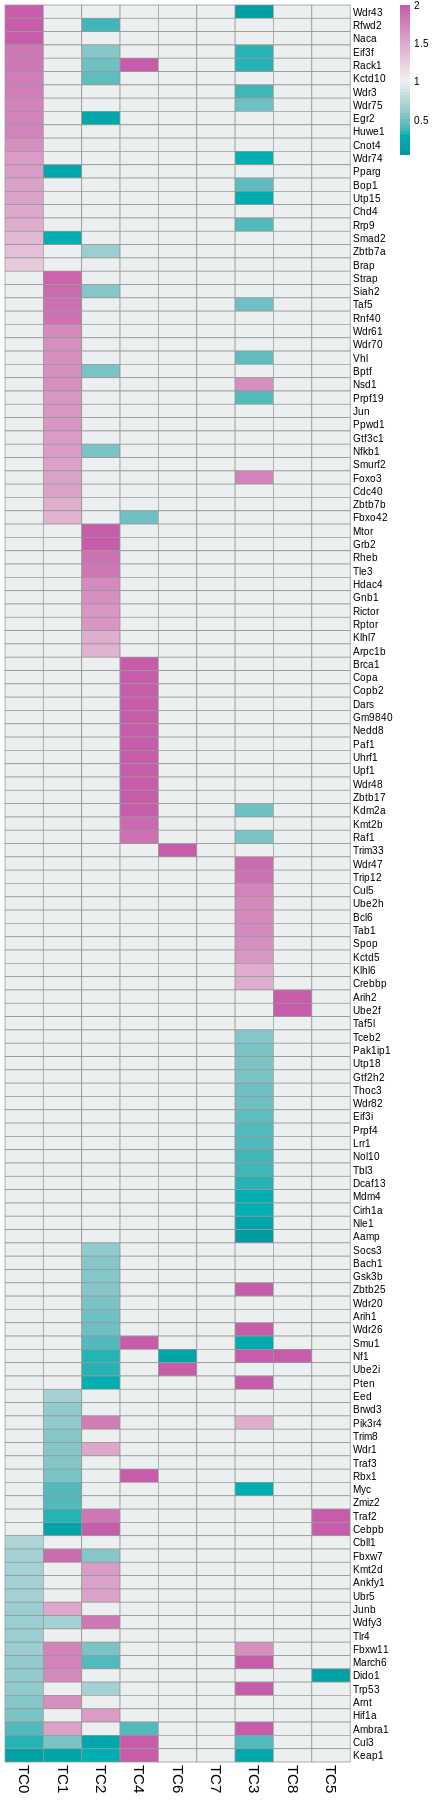

In [10]:
%%R -w 6 -h 25 -u in

rownames(kk) = sapply(rownames(kk), function(x){paste0( "TC",strsplit(as.character(x),"Leiden")[[1]][2])})
colnames(kk) <- sapply(colnames(kk), function(x){strsplit(x, "_")[[1]][2]})


kk <- kk[c("TC0", "TC1", "TC2", "TC4", "TC6", "TC7", "TC3", "TC8", "TC5"),]
kk <- data.frame(t(kk))

kk = kk[order(-kk$TC0, -kk$TC1, -kk$TC2, -kk$TC4, -kk$TC6, -kk$TC7, -kk$TC3, -kk$TC8, -kk$TC5  ),]


library(pheatmap)
xx <- pheatmap(kk,cluster_rows=F, cluster_cols=F, 
         treeheight_col=0, treeheight_row=0, 
         color=hcl.colors(50, "Tropic"), clustering_method="ward.D2",
         fontsize_col=15)

write.csv(kk, "SupFig_1Z.csv")
pdf("./SupplementaryFigures/S_2AB.pdf", width=4, height=20)
grid::grid.newpage()
grid::grid.draw(xx$gtable)
dev.off()